https://www.kaggle.com/mlg-ulb/creditcardfraud

0 : normal transaction / 1 : fraud transaction

In [5]:
import os
os.listdir('../data/')

['creditcard.csv', 'diabetes.csv', 'HAR', 'santander_cs', 'titanic']

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [7]:
card = pd.read_csv('../data/creditcard.csv')
print('card shape : ', card.shape)

card shape :  (284807, 31)


In [8]:
card.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [9]:
print('fraud rate : ',sum(card.Class == 1) / len(card))

fraud rate :  0.001727485630620034


# preprocessing

In [10]:
from sklearn.model_selection import train_test_split

In [14]:
def get_train_test_dataset(df) :
    
    #time drop
    def get_preprocessed_df(df) :
        df_copy = df.copy()
        df_copy.drop('Time', axis = 1, inplace = True)

        return df_copy
    
    
    df_copy = get_preprocessed_df(df)
    
    X_features = df_copy.iloc[:, :-1]
    y_target = df_copy.iloc[:,-1]
    
    X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size = 0.3,
                                                       random_state = 0, stratify = y_target)
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(card)

In [15]:
print('train data label rate')
print(y_train.value_counts() / len(y_train)*100)
print('test data label rate')
print(y_test.value_counts() / len(y_test)*100)

train data label rate
0    99.827451
1     0.172549
Name: Class, dtype: float64
test data label rate
0    99.826785
1     0.173215
Name: Class, dtype: float64


In [11]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

def get_eval(y_test, pred) :
    
    print('accuracy : {0:.4f} precision : {1:.4f} recall : {2:.4f} F1 : {3:.4f} AUC : {4:.4f}'.format(
                                                        accuracy_score(y_test, pred), 
                                                        precision_score(y_test, pred),
                                                        recall_score(y_test, pred),
                                                        f1_score(y_test,pred),
                                                        roc_auc_score(y_test, pred)
                                                                      ))

    print(confusion_matrix(y_test, pred))

# modeling

In [16]:
def get_model_train_eval(model, ftr_train = None, ftr_test = None, tgt_train = None, tgt_test = None) :
    
    model.fit(ftr_train ,tgt_train)
    pred = model.predict(ftr_test)
    get_eval(tgt_test, pred)

## logistic regression

In [17]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)

get_eval(y_test, lr_pred)

accuracy : 0.9992 precision : 0.8738 recall : 0.6081 F1 : 0.7171 AUC : 0.8040
[[85282    13]
 [   58    90]]


## LightGBM

In [18]:
from lightgbm import LGBMClassifier

lgb = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average = False)
#boost_from_average = False (default : True) <- imbalance data는 False로 설정해야 함

get_model_train_eval(lgb, X_train, X_test, y_train, y_test)

accuracy : 0.9995 precision : 0.9492 recall : 0.7568 F1 : 0.8421 AUC : 0.8783
[[85289     6]
 [   36   112]]


# data transformation

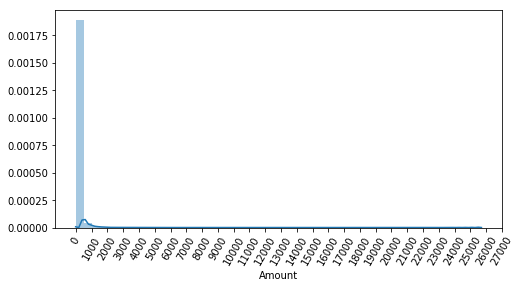

In [19]:
import seaborn as sns
plt.figure(figsize = (8,4))
plt.xticks(range(0,30000,1000), rotation = 60)
sns.distplot(card['Amount'])

In [20]:
card.Amount.describe()

count    284807.000000
mean         88.349619
std         250.120109
min           0.000000
25%           5.600000
50%          22.000000
75%          77.165000
max       25691.160000
Name: Amount, dtype: float64

## Standardization - 정규화
- logistic regression은 회귀이기 때문에, 각가의 변수들이 정규분포를 따르는 것이 좋다.
- tree based model은 별로 상관 없음

In [21]:
from sklearn.preprocessing import StandardScaler

def get_train_test_dataset(df) :
    
    def get_preprocessed_df(df) :
    
        df_copy = df.copy()
        scaler = StandardScaler()

        amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1,1))
        #정규화하여 Amount_scaled라는 이름으로 데이터프레임 맨 앞에 
        df_copy.insert(0, 'Amount_scaled', amount_n)

        df_copy.drop(['Time','Amount'], axis = 1, inplace = True)
        return df_copy
    
    
    df_copy = get_preprocessed_df(df)
    
    X_features = df_copy.iloc[:, :-1]
    y_target = df_copy.iloc[:,-1]
    
    X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size = 0.3,
                                                       random_state = 0, stratify = y_target)
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(card)

In [22]:
#after standardization
lr = LogisticRegression()
print('### logistic regression ###')
get_model_train_eval(lr, X_train, X_test, y_train, y_test)

print('### LightGBM###')
lgb = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average = False)
get_model_train_eval(lgb, X_train, X_test, y_train, y_test)

### logistic regression ###
accuracy : 0.9992 precision : 0.8654 recall : 0.6081 F1 : 0.7143 AUC : 0.8040
[[85281    14]
 [   58    90]]
### LightGBM###
accuracy : 0.9995 precision : 0.9492 recall : 0.7568 F1 : 0.8421 AUC : 0.8783
[[85289     6]
 [   36   112]]


- 하나도 좋아지지 않음

## log transformation

In [23]:
def get_train_test_dataset(df) :
    
    def get_preprocessed_df(df) :
    
        df_copy = df.copy()

        amount_n = np.log1p(df.Amount)

        #정규화하여 Amount_scaled라는 이름으로 데이터프레임 맨 앞에 
        df_copy.insert(0, 'Amount_scaled', amount_n)

        df_copy.drop(['Time','Amount'], axis = 1, inplace = True)
        return df_copy
    
    
    df_copy = get_preprocessed_df(df)
    
    X_features = df_copy.iloc[:, :-1]
    y_target = df_copy.iloc[:,-1]
    
    X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size = 0.3,
                                                       random_state = 0, stratify = y_target)
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(card)

In [24]:
#after log transformation
print('### logistic regression ###')
get_model_train_eval(lr, X_train, X_test, y_train, y_test)

print('### LightGBM###')
lgb = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average = False)
get_model_train_eval(lgb, X_train, X_test, y_train, y_test)

### logistic regression ###
accuracy : 0.9992 precision : 0.8824 recall : 0.6081 F1 : 0.7200 AUC : 0.8040
[[85283    12]
 [   58    90]]
### LightGBM###
accuracy : 0.9995 precision : 0.9576 recall : 0.7635 F1 : 0.8496 AUC : 0.8817
[[85290     5]
 [   35   113]]


# outlier

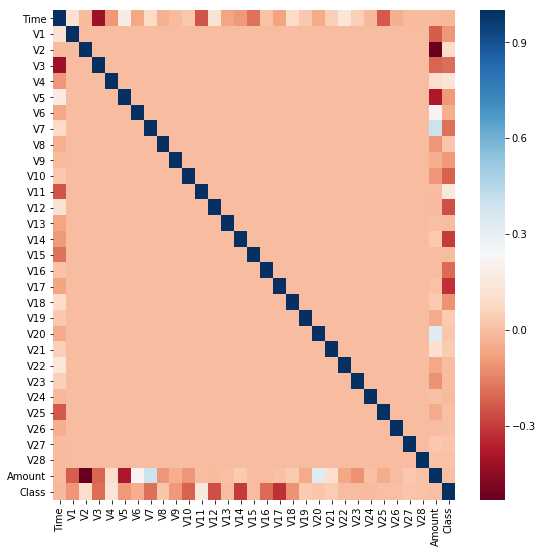

In [25]:
import seaborn as sns

plt.figure(figsize = (9,9))
corr = card.corr()
sns.heatmap(corr, cmap = 'RdBu')

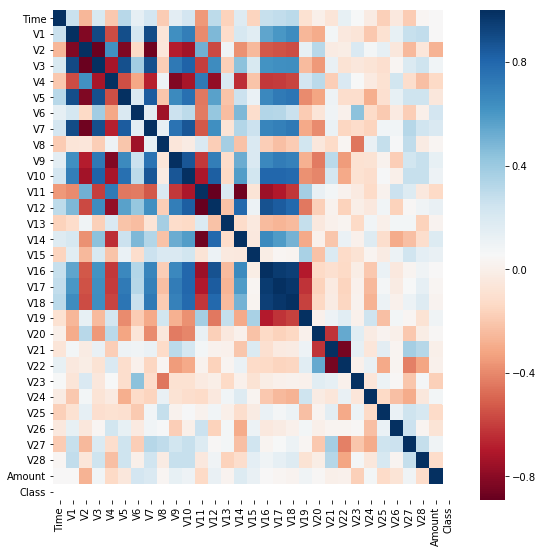

In [26]:
#fraud card correlation
plt.figure(figsize = (9,9))
corr = card[card.Class == 1].corr()
sns.heatmap(corr, cmap = 'RdBu')

In [27]:
def get_outlier(df, column, weight = 1.5) :
    
    fraud = df[df.Class == 1][column]
    
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)
    iqr = (quantile_75 - quantile_25)*weight
    
    lowest = quantile_25-iqr
    highest = quantile_75+iqr
    
    oulier_index = fraud[(fraud < lowest) | (fraud > highest)].index
    
    return oulier_index

In [28]:
oulier_index = get_outlier(card, 'V14', 1.5)
print('V14 outlier index : ', oulier_index)

V14 outlier index :  Int64Index([8296, 8615, 9035, 9252], dtype='int64')


In [29]:
def get_train_test_dataset(df) :
    
    def get_preprocessed_df(df) :

        df_copy = df.copy()

        amount_n = np.log1p(df.Amount)

        #정규화하여 Amount_scaled라는 이름으로 데이터프레임 맨 앞에 
        df_copy.insert(0, 'Amount_scaled', amount_n)

        df_copy.drop(['Time','Amount'], axis = 1, inplace = True)

        #outlier
        oulier_index = get_outlier(card, 'V14', 1.5)
        df_copy.drop(oulier_index, axis = 0, inplace = True)

        return df_copy
    
    
    df_copy = get_preprocessed_df(df)
    
    X_features = df_copy.iloc[:, :-1]
    y_target = df_copy.iloc[:,-1]
    
    X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size = 0.3,
                                                       random_state = 0, stratify = y_target)
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(card)

In [30]:
#after log transformation
print('### logistic regression ###')
get_model_train_eval(lr, X_train, X_test, y_train, y_test)

print('### LightGBM###')
get_model_train_eval(lgb, X_train, X_test, y_train, y_test)

### logistic regression ###
accuracy : 0.9993 precision : 0.8829 recall : 0.6712 F1 : 0.7626 AUC : 0.8355
[[85282    13]
 [   48    98]]
### LightGBM###
accuracy : 0.9997 precision : 0.9680 recall : 0.8288 F1 : 0.8930 AUC : 0.9144
[[85291     4]
 [   25   121]]


# SMOTE oversampling
- oversampling : 적은 데이터 세트를 증식하여 학습을 위한 충분한 데이터를 확보하는 방법. 원본 데이터으 ㅣ피처 값들을 아주 약간만 변경하여 증식.
- SMOTE(Synthetic Minority Over-sampling Technique) : 적은 데이터 세트에 있는 개별 데이터들의 KNN을 찾아서 이 데이터와 K개 이웃들의 차이를 일정 값으로 만들어서 기존 데이터와 약간 차이가 나는 새로운 데이터 생성.
- 반드시 train data만 oversampling

In [31]:
from imblearn.over_sampling import SMOTE

In [32]:
smote = SMOTE(random_state=0)
#smote 적용
X_train_over, y_train_over = smote.fit_sample(X_train, y_train)

print('before smote train data shape : ', X_train.shape, y_train.shape)
print('after smote train data shape : ', X_train_over.shape, y_train_over.shape)

before smote train data shape :  (199362, 29) (199362,)
after smote train data shape :  (398040, 29) (398040,)


In [34]:
#동일한 비율
print('after SMOTE y label rate \n', pd.Series(y_train_over).value_counts())

after SMOTE y label rate 
 1    199020
0    199020
dtype: int64


## logistic regression()

In [35]:
lr = LogisticRegression()
#recall 증가, precision 급감
get_model_train_eval(lr, X_train_over, X_test, y_train_over, y_test)

accuracy : 0.9722 precision : 0.0540 recall : 0.9247 F1 : 0.1021 AUC : 0.9485
[[82932  2363]
 [   11   135]]


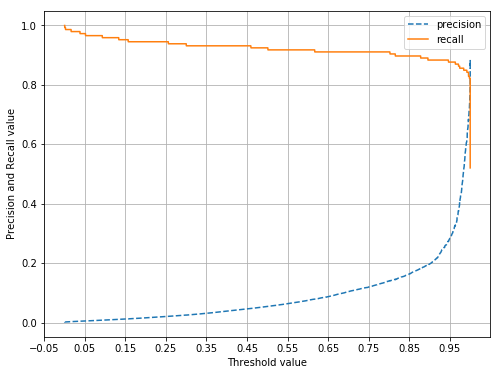

In [36]:
from sklearn.metrics import precision_recall_curve

def precision_recall_curve_plot(y_test, pred_proba_c1) :
    
    precision, recall, threshold = precision_recall_curve(y_test, pred_proba_c1)
    
    plt.figure(figsize=(8,6))
    threshold_boundary = threshold.shape[0]
    plt.plot(threshold, precision[:threshold_boundary], linestyle = '--', label = 'precision')
    plt.plot(threshold, recall[:threshold_boundary], label = 'recall')
    
    #x축의 scale을 0.1단위로
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    plt.xlabel('Threshold value')
    plt.ylabel('Precision and Recall value')
    
    plt.legend()
    plt.grid()
    plt.show()
    
precision_recall_curve_plot(y_test, lr.predict_proba(X_test)[:,1])

- logistic regression은 SMOTE 방법 안 좋아보임

## lightGBM

In [37]:
lgb = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average = False)
get_model_train_eval(lgb, X_train_over, X_test, y_train_over, y_test)

accuracy : 0.9996 precision : 0.9323 recall : 0.8493 F1 : 0.8889 AUC : 0.9246
[[85286     9]
 [   22   124]]


- SMOTE를 사용하면, 재현율은 높아지지만, 정밀도는 낮아지는 것이 일반적.